## this cell has been modified
experiments below changes are implemented in this cell

In [29]:
%load_ext blackcellmagic

In [31]:
from flask import Flask, request, render_template, jsonify, json
from decouple import config
from flask_cors import CORS
import numpy as np
import networkx as nx
import tweepy
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import re
from collections import Counter
import asyncio
from concurrent.futures import ThreadPoolExecutor
import requests
import nest_asyncio

nest_asyncio.apply()

# set up twitter environment
TWITTER_AUTH = tweepy.OAuthHandler(
    config("TWITTER_CONSUMER_KEY"), config("TWITTER_CONSUMER_SECRET")
)
TWITTER_AUTH.set_access_token(
    config("TWITTER_ACCESS_TOKEN"), config("TWITTER_ACCESS_TOKEN_SECRET")
)
TWITTER = tweepy.API(TWITTER_AUTH)


def get_first_user_interactions(search, index):
    twitter_user = TWITTER.get_user(search)
    tweets = twitter_user.timeline(
        count=200, exclude_replies=False, include_rts=True, tweet_mode="extended"
    )
    # generate a  list of tweets. join it to string. extract user names. turn
    # it into a string again.
    # b is a transistion variable
    b = [i.full_text for i in tweets]
    b = " ".join(b)
    b = b.lower()
    b = b.replace(search, "")
    # regex for extracting @twitter_handles as elements of a list
    index = re.findall(r"(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)", b)
    # return the most common  names
    return [i[0] for i in Counter(index).most_common(50)]


def get_first_user_connections_multi_process(session, search, interactions_list):
    try:
        twitter_user = TWITTER.get_user(search)
        tweets = twitter_user.timeline(
            count=200, exclude_replies=False, include_rts=True, tweet_mode="extended"
        )
        # b is a transistion variable
        b = [i.full_text for i in tweets]
        b = " ".join(b)
        b = b.lower()
        b = b.replace(search, "")
        # regex for extracting @twitter_handles as elements of a list
        interactions = re.findall(
            r"(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)", b
        )
        # turn the list to string and add it to a list
        interactions = " ".join(interactions)
        interactions_list.append(interactions)
        return interactions_list
    except:
        pass


# asynchronous coroutine
async def get_data_asynchronous(index, interactions_list):

    with ThreadPoolExecutor(max_workers=40) as executor:
        with requests.Session() as session:
            # Set any session parameters here before calling `fetch`

            # Initialize the event loop
            loop = asyncio.get_event_loop()

            # Use list comprehension to create a list of
            # tasks to complete. The executor will run the `fetch`
            # function for each csv in the csvs_to_fetch list
            # Allows us to pass in multiple arguments to `fetch`
            tasks = [
                loop.run_in_executor(
                    executor,
                    get_first_user_connections_multi_process,
                    *(session, i, interactions_list)
                )
                for i in index
            ]

            # Initializes the tasks to run and awaits their results
            for response in await asyncio.gather(*tasks):
                pass


def execute_async_event_loop(index, interactions_list):
    """Really couldn't think of a proper name. 
    This function does something analogous to compiling the get_data_asynchronously funciont,
    Then it executre loop."""
    future = asyncio.ensure_future(get_data_asynchronous(index, interactions_list))
    loop = asyncio.get_event_loop()
    loop.run_until_complete(future)
    return index, interactions_list


def get_network(user):
    #     user = request.values["user"]
    #     user = user.replace("@","")
    interactions_list = []
    index = []
    index = get_first_user_interactions(user, index)
    index = list(set([user] + index))
    index, interactions_list = execute_async_event_loop(index, interactions_list)
    # add first item to the top of the list

    # turn the interactions into a dataframe
    vectorizer = CountVectorizer(min_df=2)
    X = vectorizer.fit_transform(interactions_list)
    display_df = pd.DataFrame(
        X.toarray(), columns=vectorizer.get_feature_names(), index=index
    )
    # create a graph and add edges
    DG = nx.MultiGraph()
    for i in display_df.index.values:
        for j in display_df.columns:
            if display_df[j].loc[i] > 0:
                DG.add_edge(j, i, weight=np.sqrt(display_df[j].loc[i]))
            else:
                pass
    # create json nodes from graph
    sl_nodes = nx.spectral_layout(DG)
    node_list = list(sl_nodes)
    node_x = [sl_nodes[i][0] for i in node_list]
    node_y = [sl_nodes[i][1] for i in node_list]
    node_x = json.dumps(node_x)
    node_y = json.dumps(node_y)

    def get_column_sum(i):
        try:
            return int(display_df[i].sum())
        except:
            return 1

    node_weights = [get_column_sum(i) for i in node_list]
    node_weights = json.dumps(node_weights)
    node_list = json.dumps(node_list)

    # create json edges from graph
    edges = list(DG.edges.data())
    sl_edges_x = []
    sl_edges_y = []
    sl_edges_weight = []
    for i in range(len(edges)):
        sl_edges_x.append(sl_nodes[edges[i][0]][0])
        sl_edges_y.append(sl_nodes[edges[i][0]][1])
        sl_edges_x.append(sl_nodes[edges[i][1]][0])
        sl_edges_y.append(sl_nodes[edges[i][1]][1])
        sl_edges_weight.append(edges[i][2]["weight"])
        sl_edges_weight.append(edges[i][2]["weight"])
        sl_edges_x.append("")
        sl_edges_y.append("")
        sl_edges_weight.append("")
    x = json.dumps(sl_edges_x)
    y = json.dumps(sl_edges_y)
    weights = json.dumps(sl_edges_weight)

    user = json.dumps(user)

    #         return render_template("network.html", edge_x =x, edge_y =y, node_x =
    #         node_x, node_y =node_y, user = user, node_list=node_list,
    #         node_weights=node_weights)
    return x, y, node_x, node_y, user, node_list, node_weights

In [2]:
%%time
x, y, node_x, node_y ,user, node_list, node_weights = get_network("austen")

Wall time: 4.86 s


## Removing tweet processing 

In [27]:
from flask import Flask, request, render_template, jsonify, json
from decouple import config
from flask_cors import CORS
import numpy as np
import networkx as nx
import tweepy
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import re
from collections import Counter
import asyncio
from concurrent.futures import ThreadPoolExecutor
import requests
import nest_asyncio
nest_asyncio.apply()

#set up twitter environment
TWITTER_AUTH =tweepy.OAuthHandler(config('TWITTER_CONSUMER_KEY'),config('TWITTER_CONSUMER_SECRET'))
TWITTER_AUTH.set_access_token(config('TWITTER_ACCESS_TOKEN'),config('TWITTER_ACCESS_TOKEN_SECRET'))
TWITTER = tweepy.API(TWITTER_AUTH)


def get_first_user_timeline(search,index):
    timeline = TWITTER.user_timeline(
                    id=search,
                    count =200,
                    exclude_replies = False,
                    include_rts=True,
                    tweet_mode='extended'
                    )
    index.append([user_mentions["screen_name"] for um_list in 
             [ tweet.entities["user_mentions"] for tweet in timeline]
             for user_mentions in um_list ])

def get_first_user_favorites(search,index):
    timeline = TWITTER.favorites(
                    id=search,
                    count =200,
                    exclude_replies = False,
                    include_rts=True,
                    tweet_mode='extended'
                    )
    index.append([user_mentions["screen_name"] for um_list in 
             [ tweet.entities["user_mentions"] for tweet in timeline]
             for user_mentions in um_list ])


In [28]:
%%time
index=[]
f = get_first_user_timeline("austen",index)

Wall time: 812 ms


In [13]:
def get_first_user_interactions0(search):
    twitter_user =TWITTER.get_user(search)
    tweets = twitter_user.timeline(
                    count =200,
                    exclude_replies = False,
                    include_rts=True,
                    tweet_mode='extended'
                    )
    # generate a  list of tweets. join it to string. extract user names. turn
    # it into a string again.
    #b is a transistion variable
    b = [ i.full_text for i in tweets ]
    b = " ".join(b)
    b = b.lower()
    b = b.replace(search, "")
    #regex for extracting @twitter_handles as elements of a list
    index=re.findall(r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)',b)
        # return the most common  names
    return [ i[0] for i in Counter(index).most_common(50) ]

In [14]:
%%time
ff0 = get_first_user_interactions("austen")

Wall time: 1.38 s


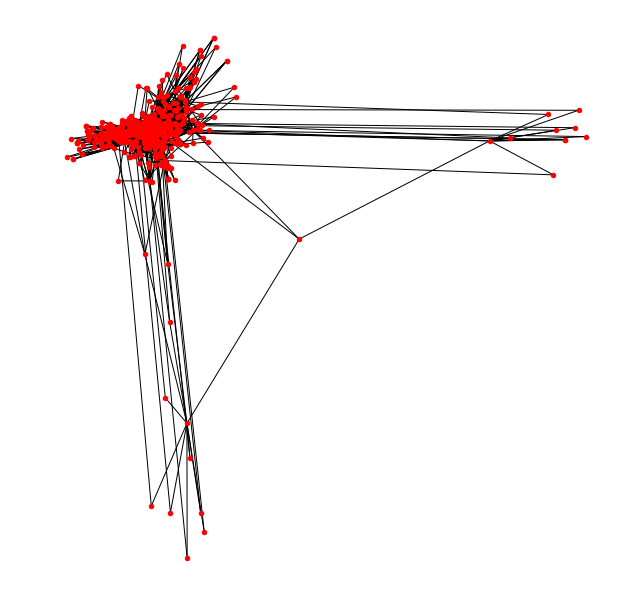

In [116]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,8))
nx.draw_spectral(DG, node_size=20)

# Experiments below

### pandas to nx experiments

In [3]:
from flask import Flask, request, render_template, jsonify, json
from decouple import config
from flask_cors import CORS
import numpy as np
import networkx as nx
import tweepy
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import re
from collections import Counter
import asyncio
from concurrent.futures import ThreadPoolExecutor
import requests
import nest_asyncio
nest_asyncio.apply()

#set up twitter environment
TWITTER_AUTH =tweepy.OAuthHandler(config('TWITTER_CONSUMER_KEY'),config('TWITTER_CONSUMER_SECRET'))
TWITTER_AUTH.set_access_token(config('TWITTER_ACCESS_TOKEN'),config('TWITTER_ACCESS_TOKEN_SECRET'))
TWITTER = tweepy.API(TWITTER_AUTH)


def get_first_user_interactions(search,index):
    twitter_user =TWITTER.get_user(search)
    tweets = twitter_user.timeline(
                    count =200,
                    exclude_replies = False,
                    include_rts=True,
                    tweet_mode='extended'
                    )
    # generate a  list of tweets. join it to string. extract user names. turn
    # it into a string again.
    #b is a transistion variable
    b = [ i.full_text for i in tweets ]
    b = " ".join(b)
    b = b.lower()
    b = b.replace(search, "")
    #regex for extracting @twitter_handles as elements of a list
    index=re.findall(r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)',b)
        # return the most common  names
    return [ i[0] for i in Counter(index).most_common(50) ]
def get_first_user_connections_multi_process(session, search, interactions_list):
    try:
        twitter_user =TWITTER.get_user(search)
        tweets = twitter_user.timeline(
                    count =200,
                    exclude_replies = False,
                    include_rts=True,
                    tweet_mode='extended'
                    )
        #b is a transistion variable
        b = [ i.full_text for i in tweets ]
        b = " ".join(b)
        b = b.lower()
        b = b.replace(search, "")
        #regex for extracting @twitter_handles as elements of a list
        interactions = re.findall(r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)',b)

        interactions= [ (search, i) for i in interactions]
        interactions_list.append(interactions)
        return interactions_list
    except:
        pass

#asynchronous coroutine
async def get_data_asynchronous(index,interactions_list):
    
    with ThreadPoolExecutor(max_workers=40) as executor:
        with requests.Session() as session:
            # Set any session parameters here before calling `fetch`

            # Initialize the event loop        
            loop = asyncio.get_event_loop()
            
            
            # Use list comprehension to create a list of
            # tasks to complete. The executor will run the `fetch`
            # function for each csv in the csvs_to_fetch list
            # Allows us to pass in multiple arguments to `fetch`
            tasks = [ loop.run_in_executor(
                executor, get_first_user_connections_multi_process,*(session, i, interactions_list) 
            ) for i in index]
            
            # Initializes the tasks to run and awaits their results
            for response in await asyncio.gather(*tasks):
                pass
            
def execute_async_event_loop(index,interactions_list):
    """Really couldn't think of a proper name. 
    This function does something analogous to compiling the get_data_asynchronously funciont,
    Then it executre loop."""
    future = asyncio.ensure_future(get_data_asynchronous(index,interactions_list))
    loop = asyncio.get_event_loop()
    loop.run_until_complete(future)
    
    return index, interactions_list
    
def get_network(user):
    #     user = request.values["user"]
    #     user = user.replace("@","")
    interactions_list = []
    index = []
    index = get_first_user_interactions(user,index)
    index = list(set([user] +index))
    index, interactions_list = execute_async_event_loop(index,interactions_list)
    #add first item to the top of the list

    #turn the interactions into a dataframe

    all_interactions =  [ i for sublist in interactions_list for i in sublist ]
    df = pd.DataFrame(all_interactions, columns=['source_user', 'interaction_user'])
    df_group = df.groupby(['source_user','interaction_user']).size().reset_index().rename(columns={0: "count"})
    a = df_group.groupby('source_user')['count'].transform('sum')
    df_group['weight'] = df_group['count'].div(a)
    DG = nx.from_pandas_edgelist(df_group, "source_user", "interaction_user",
                        edge_attr=['weight', "count"], 
                         create_using=nx.MultiGraph())
    #create json nodes from graph
    sl_nodes = nx.spectral_layout(DG)
    node_list = list(sl_nodes)
    node_x = [sl_nodes[i][0] for i in node_list]
    node_y = [sl_nodes[i][1] for i in node_list]
    node_x = json.dumps(node_x)
    node_y = json.dumps(node_y)
    def get_column_sum(i):
        try:
            return int(display_df[i].sum())
        except:
            return 1
    node_weights = [ get_column_sum(i) for i in node_list ]
    node_weights = json.dumps(node_weights)
    node_list = json.dumps(node_list)

    #create json edges from graph
    edges = list(DG.edges.data())
    sl_edges_x = []
    sl_edges_y = []
    sl_edges_weight = []
    for i in range(len(edges)):
        sl_edges_x.append(sl_nodes[edges[i][0]][0])
        sl_edges_y.append(sl_nodes[edges[i][0]][1])
        sl_edges_x.append(sl_nodes[edges[i][1]][0])
        sl_edges_y.append(sl_nodes[edges[i][1]][1])
        sl_edges_weight.append(edges[i][2]["weight"])
        sl_edges_weight.append(edges[i][2]["weight"])
        sl_edges_x.append("")
        sl_edges_y.append("")
        sl_edges_weight.append("")
    x = json.dumps(sl_edges_x)
    y = json.dumps(sl_edges_y)
    weights = json.dumps(sl_edges_weight)

    user = json.dumps(user)

    #         return render_template("network.html", edge_x =x, edge_y =y, node_x =
    #         node_x, node_y =node_y, user = user, node_list=node_list,
    #         node_weights=node_weights)
    return x, y, node_x, node_y ,user, node_list, node_weights, df_group


In [4]:
%%time
#df_group, DG = get_network("austen")
x, y, node_x, node_y ,user, node_list, node_weights, df_group = get_network("austen")

Wall time: 4.31 s


In [43]:
le

5382

In [5]:
nx.draw_spectral(DG, node_size=20)

NameError: name 'DG' is not defined

In [176]:
df_group.shape

(6581, 4)

In [169]:
nodes = json.loads(node_list)

In [177]:
nodes

['a16z',
 'abadesi',
 'acadiant',
 'alaeven',
 'alecstapp',
 'alexjfang',
 'ali01',
 'almarrone',
 'alxsolomon',
 'amiklas',
 'andrew_radin',
 'andrewchen',
 'appcardiogram',
 'apple',
 'arampell',
 'astrange',
 'axios',
 'bankmercury',
 'bardo',
 'baskarfx',
 'benafisch',
 'bencasnocha',
 'benedictevans',
 'benhoffman_',
 'bhoro',
 'bhorowitz',
 'binodhq',
 'celohq',
 'chadloder',
 'chloecondon',
 'christinalopes_',
 'christine__zhu',
 'christopherfong',
 'chuhnk',
 'clemnt',
 'cmschroed',
 'cnbc',
 'cnbcmakeit',
 'conniechan',
 'cpownall',
 'da',
 'daljeetvirdi',
 'daphnekoller',
 'davidu',
 'dcasha',
 'dclarke88',
 'deantak',
 'dgnpartap',
 'drivorhorn',
 'edalvarezb',
 'eladgil',
 'endpts',
 'eriktorenberg',
 'fortunemagazine',
 'freenome',
 'ft',
 'gdibner',
 'gentrifighter',
 'geoffreykeating',
 'give_directly',
 'gkossakowski',
 'gvinzelles',
 'iiterature',
 'immad',
 'insidenima',
 'insitro',
 'jadtnaous',
 'janicemccallum',
 'jeff_jordan',
 'jeffreylowmd',
 'jefftijssen',
 'je

## async experiments

In [25]:
def get_network(user):
#     user = request.values["user"]
#     user = user.replace("@","")
        interactions_list = []
        index = []
        index = get_first_user_interactions(user,index)
        index = list(set([user] +index))
        return index, interactions_list
        

In [32]:
index, interactions_list = get_network("austen")

In [33]:
# from multiprocessing import Process, Pool
# pool = Pool(processes=5)
# results = pool.map(get_first_user_connections, (index, interactions_list))

In [34]:
#!pip install aiohttp

In [79]:
#example 1
import asyncio
from concurrent.futures import ThreadPoolExecutor
import requests

#asynchronous coroutine
async def get_data_asynchronous(index,interactions_list):

    # Note: max_workers is set to 10 simply for this example,
    # you'll have to tweak with this number for your own projects
    # as you see fit
    
    with ThreadPoolExecutor(max_workers=40) as executor:
        with requests.Session() as session:
            # Set any session parameters here before calling `fetch`

            # Initialize the event loop        
            loop = asyncio.get_event_loop()
            
            # Set the START_TIME for the `fetch` function
            START_TIME = default_timer()
            
            # Use list comprehension to create a list of
            # tasks to complete. The executor will run the `fetch`
            # function for each csv in the csvs_to_fetch list
            # Allows us to pass in multiple arguments to `fetch`
            tasks = [ loop.run_in_executor(executor, get_first_user_connections_multi_process,*(session, i, interactions_list) ) for i in index]
            
            # Initializes the tasks to run and awaits their results
            for response in await asyncio.gather(*tasks):
                pass
def main(index,interactions_list):
    future = asyncio.ensure_future(get_data_asynchronous(index,interactions_list))
    loop = asyncio.get_event_loop()
    loop.run_until_complete(future)
    return index, interactions_list

In [66]:
#!pip install nest-asyncio

In [67]:
import nest_asyncio
nest_asyncio.apply()

In [80]:
%%time
index, interactions_list = get_network("austen")
index, interactions_list = main(index, interactions_list)

ValueError: empty vocabulary; perhaps the documents only contain stop words

In [82]:
interactions_list

['wiggins_dakoda sophiet maisie_williams zimvc hashim_warren mandalane_ kailavansumer lambdaschool shrmnshrmn lambdaschool webdevmason realjohngatto raulrpearson jnicolemorgan jnicolemorgan wellpaidgeek mispelledtoyota mispelledtoyota indianaboognish mispelledtoyota figmadesign jd_hirsch florinpop1705 windows apple florinpop1705 iginakay reverendjrod rvawonk knightopia rtp1111 newsbreaking chevrolet jnicolemorgan toriglass jnicolemorgan toriglass argumatronic jnicolemorgan sschaefer01 evsportscorp liturgy florinpop1705 jnicolemorgan jnicolemorgan quiara thunmont eanton781 cindy_w_brandt jnicolemorgan mellos_journey lambdaschool career_karma mellos_journey lambdaschool career_karma beardyblue tudorgrrrl beboplouise karnythia rbrutti infinite_scream getify botsbreeder moeamaya elyktrix jnicolemorgan jnicolemorgan jnicolemorgan jnicolemorgan evansvillewatch inflammatorydev getify inflammatorydev getify florinpop1705 shiffman mpjme getify getify getify austen jnicolemorgan kyleshevlin geti

In [71]:
#example2
import aiohttp
import asyncio
import async_timeout
import os
 
async def get_data_asynchronous(index,interactions_list):
    with async_timeout.timeout(10):
        get_first_user_connections_multi_process(session,i_index)

async def main(loop, index):
    tasks = [get_data_asynchronous(session, i) for i in index]
    await asyncio.gather(*tasks)

if __name__ == '__main__':
    loop = asyncio.get_event_loop()
    loop.run_until_complete(main(loop,index))
main(loop,index)

In [70]:
len(interactions_list), len(index)

(31, 31)

ERROR! Session/line number was not unique in database. History logging moved to new session 638


NameError: name 'session' is not defined

In [29]:
def get_network_full(user):
#     user = request.values["user"]
#     user = user.replace("@","")
        interactions_list = []
        index = []
        index = get_first_user_interactions(user,index)
        index = list(set([user] +index))
        interactions_list = main(index, interactions_list)
        #add first item to the top of the list

        #turn the interactions into a dataframe
        vectorizer = CountVectorizer(min_df=2)
        X = vectorizer.fit_transform(interactions_list)
        display_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names(), index=index)
        #create a graph and add edges
        DG = nx.MultiGraph()
        for i in display_df.index.values:
            for j in display_df.columns:
                if display_df[j].loc[i] > 0:
                    DG.add_edge(j,i,weight = np.sqrt(display_df[j].loc[i] ))
                else:
                    pass
        #create json nodes from graph
        sl_nodes = nx.spectral_layout(DG)
        node_list = list(sl_nodes)
        node_x = [sl_nodes[i][0] for i in node_list]
        node_y = [sl_nodes[i][1] for i in node_list]
        node_x = json.dumps(node_x)
        node_y = json.dumps(node_y)
        def get_column_sum(i):
            try:
                return int(display_df[i].sum())
            except:
                return 1
        node_weights = [ get_column_sum(i) for i in node_list ]
        node_weights = json.dumps(node_weights)
        node_list = json.dumps(node_list)

        #create json edges from graph
        edges = list(DG.edges.data())
        sl_edges_x = []
        sl_edges_y = []
        sl_edges_weight = []
        for i in range(len(edges)):
            sl_edges_x.append(sl_nodes[edges[i][0]][0])
            sl_edges_y.append(sl_nodes[edges[i][0]][1])
            sl_edges_x.append(sl_nodes[edges[i][1]][0])
            sl_edges_y.append(sl_nodes[edges[i][1]][1])
            sl_edges_weight.append(edges[i][2]["weight"])
            sl_edges_weight.append(edges[i][2]["weight"])
            sl_edges_x.append("")
            sl_edges_y.append("")
            sl_edges_weight.append("")
        x = json.dumps(sl_edges_x)
        y = json.dumps(sl_edges_y)
        weights = json.dumps(sl_edges_weight)

        user = json.dumps(user)
        return display_df, DG
#         return render_template("network.html", edge_x =x, edge_y =y, node_x =
#         node_x, node_y =node_y, user = user, node_list=node_list,
#         node_weights=node_weights)


In [30]:
get_network_full("austen")

RuntimeError: This event loop is already running

kailavansumer
a16z
rogerdickey
lambdaschool
uber
stevenglinert
informema
hashim_warren
honestduane
gillianim
yvng_lorde austen nickjbasile coursereport austen austen mispelledtoyota justinandrade_j reactweek dustint314 meaghanbarber9 meaghanbarber9 meaghanbarber9 kylasdesign mitchellgbudge austen austen mckaywrigley austen austen justsml austen austen austen austen paystack austen austen sfchronicle jiovan podiumhq brockmrohloff jasutherlandbks mark_orielly austen austen austen austen austen austen austen calebhicks tylercowen austen danielgross jesslivingston austen lisapfeffer austen ad_lc17 austen austen danielgross twitch tommycollison at_neuner veritasimpact waffluv laney5net austen austen pioneerdotapp austen katyhollobaugh fireinjundev nandotheessen la nandotheessen austen tylerwillis mckaywrigley tommycollison austen austen austen austen shaunmmaguire austen twentyminutevc austen austen austen thebigknell austen coetry austen austen austen micahmerrick launchacademy thinkful au

mark_forrester robhope jasonpatricksc wesbos gabwhite code4blessings sarah_edo netlify code4blessings code4blessings gravityview code4blessings jessfraz riyaznet javascriptdaily wes_mister gatsbyjs quinnmcphail gatsbyjs mandalane_ austen jasonsbarr kailavansumer lambdaschool austen jasonsbarr mandalane_ kailavansumer lambdaschool mandalane_ jasonsbarr kailavansumer lambdaschool austen jasonsbarr mandalane_ kailavansumer lambdaschool jasonsbarr mandalane_ kailavansumer lambdaschool jasonsbarr mandalane_ kailavansumer lambdaschool mandalane_ kailavansumer lambdaschool mandalane_ kailavansumer lambdaschool mandalane_ kailavansumer lambdaschool mandalane_ kailavansumer lambdaschool frontendmentor charronkotd markdalgleish dburka katebour coderfoundry codepo8 evanplaice evanplaice stufinn justinwhall rafaelf03113877 elisheba_lang freecodecamp pwnb0xes nerdnomadmom pickleat code4blessings code4blessings undef_obj kregenrek andrew_j_mead awsamplify misshelenasue cynetjobs sandricop monteiro p

arigesher billgates sapinker dbeyer123 ilyasu susanthesquark nytopinion m2jr nytimes austen nunzi46 speirin usnews lambdaschool a16z uber lambdaschool bjc290 usnews speirin usnews lambdaschool a16z uber bznotes swiftonsecurity speirin usnews lambdaschool a16z usnews stevesi beardigsit janamal tedr sacca manukumar angelina_g_c codeboten stuartawillson bjc290 angelina_g_c hnshah jasonfesta mqsley kennethn alexrkonrad mattocko mattocko mulegirl dastartuphunter buckymoore cxtiff j_n_s jeff_jordan conniechan a16z pinterest ciaosamin powerdns_bert pkedrosky kimbatronic mattocko writerstrategy kamilszybalski ciscoumbrella stevesi waldojaquith juliadewahl bonatsos equifax nova_credit gcvp skupor andrewchen chris_walker_ equifax jess ataussig equifax arampell grlalx borisjabes equifax ataussig equifax arampell sacca equifax peter_lauten equifax neeraj jhooks mulegirl johnofa jenntejada pagerduty alxsolomon amiklas baskarfx ryangraves lipmanb katies rklau dpatil therealfitz nicolewong goldman jo

hungryroot amplehills onthemedia productcouncil kfriedrich mbrownstein89 themexican corymoelis alexrkonrad lrubinson lrubinson mets lrubinson mets curlycakes gillianim ariannasimpson domotalk peter_bukowski tampabaytre nyccomptroller annevclark yaaaaaaaaari jaykapoornyc julcuba shaig bradfitz isapalindrome rodhilton entrepreneursf relatableboss ivetetecedor brianfeist1 benzado ecantor aaronnblock brianfeist1 dingertracker dcoolican thestalwart justinkan openreelvideo mikeisaac sruhle eringriffith hungryroot susan_hennessey beyerstein kateefeldman philtoronto michaelgbaron anniecase1 harvardhbs financialgym jemelehill techladyallison alisongriswold nypdnews shaig humairawins shaig barstoolsports bizcarson connolly_s assaf maggie162 katieeperry nickseguin chicktech adampaulmoore chaseditz y_molodtsov adampaulmoore y_molodtsov incunabula lpolovets dontburntheday rottenindenmark ezraklein cedricfaiche mikemayermmo jonathanlanday ptsi impcapital impcapital impcapital cnn marvelcomicman dave

lpolovets alibhamed brentbeshore briannekimmel david_perell morganhousel zackkanter paulg tlrobinson lambdaschool online_lorraine saleh_digital durbdawg lambdaschool austen lambdaschool antoniogm atabarrok ericrweinstein ericrweinstein dotpem austen atbenedict lambdaschool eek637 lambdaschool atbenedict lambdaschool aboodman lambdaschool nicklovescode lambdaschool thinman austen lambdaschool thinman austen lambdaschool thinman austen lambdaschool aboodman lambdaschool lambdaschool patrickc bwertz thomassowell proffeynman robgmacfarlane eriktorenberg jorgeo bhadrasandeep dbeyer123 bhadrasandeep dbeyer123 bhadrasandeep dbeyer123 illusdept arturkesik nicklovescode austen lennypruss dbeyer123 ha1331 thepeoplescube alsharaf17 alan_btc paulg stephaniekelton dbeyer123 zackbloom eriktorenberg jerrytalton jackrim1 alan_btc paulg stephaniekelton paulg stephaniekelton jesslivingston siddharth87 justinkan siddharth87 justinkan kevinsimler taylorpearsonme justinkan andy_matuschak tristanharris bmnd

gzamann gzamann js_tut triketora nwthomas_ career_karma aspittel career_karma nwthomas_ career_karma sarahjpeace sarahjpeace sarahjpeace austen durbdawg mckaywrigley lambdaschool mckaywrigley lambdaschool austen hashim_warren austen jasonsbarr kailavansumer lambdaschool hashim_warren jasonsbarr kailavansumer lambdaschool hashim_warren kailavansumer lambdaschool hashim_warren kailavansumer lambdaschool hashim_warren kailavansumer lambdaschool kailavansumer lambdaschool kailavansumer lambdaschool durbdawg kailavansumer lambdaschool durbdawg wellpaidgeek durbdawg hana_rih parissathena js_tut wellpaidgeek wellpaidgeek jsjoeio jsjoeio clairesouthwe11 codenewbies sir_wernich molly_struve workingjubilee beaufortaustin wellpaidgeek javascript_jess googlechrome javascript_jess googlechrome christians_gina beaufortaustin pabloshampoo sarahjpeace almightycthaeh lambdaschool s_mbenedetti austen catmomchristina austen maybekatz mikelanders nwthomas_ lambdaschool mikelanders nwthomas_ lambdaschool n

kerooke hankrsmith shl austen atbenedict shl austen atbenedict austen atbenedict yossy770 austen dallenallred atbenedict austen yossy770 austen dallenallred austen balajis danprimack mg0314a lambdaschool austen austen austen reformedbroker austen ryansweb lambdaschool lambdaschool assetdesignnetw placebocapital austen dougcollinsux webdevmason austen hamids tesla mitchellgbudge lambdaschool elonmusk austen alanmcole hillelogram byrosenberg scottew austen mackenzief jetblue josefspalenka at_neuner lambdaschool austen grssnbchr angelozehr shreyasjothish lambdaschool lambdaschool patio11 ne0liberal joelgrus ivanahuckova lambdaschool bwinterrose weworkremotely lambdaschool eeyitemi lambdaschool jdan altimor noahpinion austen chrisalbon traceoddity wholesomememe titratecode lambdaschool austen kevinfromutah byu lambdaschool austen austen austinlieb ryan_holdaway ne0liberal ne0liberal ceo_plus_ch jonerlichman phl43 devisridhar austen calebhicks jdan itsladykadie lambdaschool ufwupdates elonm

wiggins_dakoda sophiet maisie_williams zimvc hashim_warren mandalane_ kailavansumer lambdaschool shrmnshrmn lambdaschool webdevmason realjohngatto raulrpearson jnicolemorgan jnicolemorgan wellpaidgeek mispelledtoyota mispelledtoyota indianaboognish mispelledtoyota figmadesign jd_hirsch florinpop1705 windows apple florinpop1705 iginakay reverendjrod rvawonk knightopia rtp1111 newsbreaking chevrolet jnicolemorgan toriglass jnicolemorgan toriglass argumatronic jnicolemorgan sschaefer01 evsportscorp liturgy florinpop1705 jnicolemorgan jnicolemorgan quiara thunmont eanton781 cindy_w_brandt jnicolemorgan mellos_journey lambdaschool career_karma mellos_journey lambdaschool career_karma beardyblue tudorgrrrl beboplouise karnythia rbrutti infinite_scream getify botsbreeder moeamaya elyktrix jnicolemorgan jnicolemorgan jnicolemorgan jnicolemorgan evansvillewatch inflammatorydev getify inflammatorydev getify florinpop1705 shiffman mpjme getify getify getify austen jnicolemorgan kyleshevlin getify